In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet101, ResNet101_Weights
import matplotlib.pyplot as plt

In [2]:
# ===============================================================
# BLOQUE DE IMPORTACIONES CONSOLIDADO
# ===============================================================
import random
from io import BytesIO
from typing import Callable, Dict
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch.nn.functional as F
import torch.optim as optim
import datetime
from pathlib import Path
from tqdm.auto import tqdm

import cv2
import lmdb
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations.geometric import (
    Resize,
    RandomRotate90,
    HorizontalFlip,
    VerticalFlip,
)
from albumentations.augmentations.geometric.functional import (
    hflip,
    vflip,
    resize as fresize,
)
from albumentations.pytorch import ToTensorV2

class PNGCompressionAugmentation(ImageOnlyTransform):
    """
    Aplica una compresión PNG en memoria para simular el guardado y recarga
    de una imagen en formato sin pérdidas.
    """
    def __init__(self, always_apply=False, p=1.0):
        # Usamos p=1.0 para que se aplique siempre, como en el paper.
        super().__init__(always_apply=always_apply, p=p)

    def apply(self, img, **params):
        # Codifica la imagen a formato PNG en un buffer de memoria
        success, buffer = cv2.imencode('.png', img)

        if success:
            # Si la codificación fue exitosa, decodifica desde el buffer
            img_reloaded = cv2.imdecode(buffer, cv2.IMREAD_COLOR)
            return img_reloaded
        else:
            # Si falla por alguna razón, devuelve la imagen original
            return img


# ===============================================================
# CLASES DE TRANSFORMACIÓN PERSONALIZADAS
# ===============================================================

class Transform_with_edge(DualTransform):
    @property
    def targets(self) -> Dict[str, Callable]:
        return {
            "image": self.apply,
            "mask": self.apply_to_mask,
            "masks": self.apply_to_masks,
            "bboxes": self.apply_to_bboxes,
            "keypoints": self.apply_to_keypoints,
            "edge": self.apply_to_edge,
        }

    def apply_to_edge(self, img: np.ndarray, **params) -> np.ndarray:
        raise NotImplementedError


class Resize_with_Edge(Transform_with_edge, Resize):
    def __init__(self, height, width, interpolation=cv2.INTER_LINEAR, p=1.0):
        # Primero, se llama al constructor de la clase base de albumentations
        # de forma explícita y correcta.
        Resize.__init__(self, height=height, width=width, interpolation=interpolation, p=p)
        
        # También guardamos height y width en la instancia para asegurar
        # que siempre estén disponibles.
        self.height = height
        self.width = width

    def apply_to_edge(
        self, img: np.ndarray, interpolation=cv2.INTER_NEAREST, **params
    ) -> np.ndarray:
        # Ahora self.height y self.width existen y esta línea no dará error.
        return fresize(
            img,
            height=self.height // 4,
            width=self.width // 4,
            interpolation=interpolation,
        )


class Rotate_with_Edge(Transform_with_edge, RandomRotate90):
    def __init__(self, p=0.5):
        super(RandomRotate90, self).__init__(p=p)

    def apply_to_edge(self, img: np.ndarray, factor=0, **params) -> np.ndarray:
        return np.ascontiguousarray(np.rot90(img, factor))


class HorizontalFlip_with_Edge(Transform_with_edge, HorizontalFlip):
    def __init__(self, p=0.5):
        super(HorizontalFlip, self).__init__(p=p)

    def apply_to_edge(self, img: np.ndarray, **params) -> np.ndarray:
        return hflip(img)


class VerticalFlip_with_Edge(Transform_with_edge, VerticalFlip):
    def __init__(self, p=0.5):
        super(VerticalFlip, self).__init__(p=p)

    def apply_to_edge(self, img: np.ndarray, **params) -> np.ndarray:
        return vflip(img)


class Edge_generator(nn.Module):
    """Genera el 'borde' para una máscara binaria (0-1)."""

    def __init__(self, kernel_size=3):
        super().__init__()
        self.kernel_size = kernel_size

    def _dilate(self, image, kernel_size=3):
        assert kernel_size % 2 == 1, "El tamaño del kernel debe ser impar"

        kernel = torch.zeros(
            (1, 1, kernel_size, kernel_size), device=image.device
        )
        kernel[0, 0, kernel_size // 2, :] = 1
        kernel[0, 0, :, kernel_size // 2] = 1

        res = F.conv2d(
            image,
            kernel.view([1, 1, kernel_size, kernel_size]),
            stride=1,
            padding=kernel_size // 2,
        )
        return (res > 0).float()

    def _find_edge(self, image, kernel_size=3, return_all=False):
        image = image.clone().float()
        if image.ndim == 2:
            image = image.view(1, 1, image.shape[0], image.shape[1])
        elif image.ndim == 3:
            image = image.view(1, image.shape[0], image.shape[1], image.shape[2])
        
        assert image.shape[1] == 1, "La imagen debe ser de un solo canal"

        img_dilated = self._dilate(image, kernel_size=kernel_size)
        erosion = 1.0 - self._dilate(1.0 - image, kernel_size=kernel_size)

        diff = img_dilated - erosion

        if return_all:
            return diff, img_dilated, erosion
        else:
            return diff

    def forward(self, x, return_all=False):
        return self._find_edge(x, self.kernel_size, return_all=return_all)


class RandomCopyMove(Transform_with_edge):
    def __init__(self, max_h=256, max_w=256, min_h=50, min_w=50, mask_value=255, p=0.5):
        super().__init__(p=p)
        self.max_h, self.max_w, self.min_h, self.min_w = max_h, max_w, min_h, min_w
        self.mask_value = mask_value
        self.edge_generator = Edge_generator(kernel_size=7)

    def _get_random_window(
        self, img_height, img_width, window_height=None, window_width=None
    ):
        if window_width is None or window_height is None:
            window_h = np.random.randint(self.min_h, self.max_h)
            window_w = np.random.randint(self.min_w, self.max_w)
        else:
            window_h, window_w = window_height, window_width

        pos_h = np.random.randint(0, img_height - window_h)
        pos_w = np.random.randint(0, img_width - window_w)
        return pos_h, pos_w, window_h, window_w

    def apply(self, img: np.ndarray, **params) -> np.ndarray:
        image = img.copy()
        H, W, _ = image.shape
        c_pos_h, c_pos_w, c_window_h, c_window_w = self._get_random_window(H, W)
        self.p_pos_h, self.p_pos_w, _, _ = self._get_random_window(
            H, W, c_window_h, c_window_w
        )
        self.p_window_h, self.p_window_w = c_window_h, c_window_w

        copy_region = image[
            c_pos_h : c_pos_h + c_window_h, c_pos_w : c_pos_w + c_window_w, :
        ]
        image[
            self.p_pos_h : self.p_pos_h + self.p_window_h,
            self.p_pos_w : self.p_pos_w + self.p_window_w,
            :,
        ] = copy_region
        return image

    def apply_to_mask(self, img: np.ndarray, **params) -> np.ndarray:
        img = img.copy()
        img[
            self.p_pos_h : self.p_pos_h + self.p_window_h,
            self.p_pos_w : self.p_pos_w + self.p_window_w,
        ] = self.mask_value
        self.latest_mask = img / 255.0
        return img

    def apply_to_edge(self, img: np.ndarray, **params) -> np.ndarray:
        mask_tensor = torch.from_numpy(self.latest_mask).float()
        return self.edge_generator(mask_tensor)[0][0].numpy()


class RandomInpainting(Transform_with_edge):
    def __init__(
        self, max_h=256, max_w=256, min_h=50, min_w=50, mask_value=255, p=0.5
    ):
        super().__init__(p=p)
        self.max_h, self.max_w, self.min_h, self.min_w = max_h, max_w, min_h, min_w
        self.mask_value = mask_value
        self.edge_generator = Edge_generator(kernel_size=15)

    def _get_random_window(self, img_height, img_width):
        window_h = np.random.randint(self.min_h, self.max_h)
        window_w = np.random.randint(self.min_w, self.max_w)
        pos_h = np.random.randint(0, img_height - window_h)
        pos_w = np.random.randint(0, img_width - window_w)
        return pos_h, pos_w, window_h, window_w

    def apply(self, img: np.ndarray, **params) -> np.ndarray:
        img_uint8 = img.copy().astype(np.uint8)
        H, W, _ = img_uint8.shape
        mask = np.zeros((H, W), dtype=np.uint8)
        self.pos_h, self.pos_w, self.window_h, self.window_w = self._get_random_window(
            H, W
        )
        mask[
            self.pos_h : self.pos_h + self.window_h,
            self.pos_w : self.pos_w + self.window_w,
        ] = 1
        inpaint_flag = cv2.INPAINT_TELEA if random.random() > 0.5 else cv2.INPAINT_NS
        img_inpainted = cv2.inpaint(img_uint8, mask, 3, inpaint_flag)
        return img_inpainted.astype(img.dtype)

    def apply_to_mask(self, img: np.ndarray, **params) -> np.ndarray:
        img = img.copy()
        img[
            self.pos_h : self.pos_h + self.window_h,
            self.pos_w : self.pos_w + self.window_w,
        ] = self.mask_value
        self.latest_mask = img / 255.0
        return img

    def apply_to_edge(self, img: np.ndarray, **params) -> np.ndarray:
        mask_tensor = torch.from_numpy(self.latest_mask).float()
        return self.edge_generator(mask_tensor)[0][0].numpy()


# ===============================================================
# CLASE DATASET DE PYTORCH
# ===============================================================

class LMDBAlbumentationsDataset(Dataset):
    def __init__(self, lmdb_path, keys, image_size, is_train=True):
        self.lmdb_path = lmdb_path
        self.keys = keys
        self.image_size = image_size
        self.is_train = is_train
        self.env = None
        self.edge_generator = Edge_generator(kernel_size=7)

        if is_train:
            self.transform = A.Compose(
                [
                    Resize_with_Edge(height=image_size, width=image_size),
                    Rotate_with_Edge(p=0.5),
                    HorizontalFlip_with_Edge(p=0.5),
                    VerticalFlip_with_Edge(p=0.5),
                    PNGCompressionAugmentation(p=1.0),
                    A.RandomBrightnessContrast(p=0.2),
                    A.Blur(p=0.1),
                    A.ImageCompression(quality_lower=70, quality_upper=100, p=0.2),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2(transpose_mask=True),
                ],
                additional_targets={"edge": "mask"},
            )
        else:
            self.transform = A.Compose(
                [
                    Resize_with_Edge(height=image_size, width=image_size),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2(transpose_mask=True),
                ],
                additional_targets={"edge": "mask"},
            )
            
    def _init_db(self):
        self.env = lmdb.open(
            self.lmdb_path,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False,
        )

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        if self.env is None:
            self._init_db()

        key = self.keys[idx]
        try:
            with self.env.begin(write=False) as txn:
                image_buffer = txn.get(f"image-{key}".encode("utf-8"))
                mask_buffer = txn.get(f"label-{key}".encode("utf-8"))

            if image_buffer is None or mask_buffer is None:
                raise IOError(f"Buffer vacío para la clave {key}")

            image_pil = Image.open(BytesIO(image_buffer)).convert("RGB")
            mask_pil = Image.open(BytesIO(mask_buffer)).convert("L")

            image_np = np.array(image_pil)
            mask_np = np.array(mask_pil)
            
            mask_tensor_for_edge = (
                torch.from_numpy(mask_np.copy()).float().unsqueeze(0).unsqueeze(0)
                / 255.0
            )
            edge_np = self.edge_generator(mask_tensor_for_edge).squeeze().numpy()

            transformed = self.transform(image=image_np, mask=mask_np, edge=edge_np)

            image_tensor = transformed["image"]
            mask_tensor = transformed["mask"].float() / 255.0      # ⬅️ normaliza

            edge_tensor = transformed["edge"].float()              # ya en 0–1


            is_manipulated = 1.0 if torch.max(mask_tensor) > 0 else 0.0
            label = torch.tensor([is_manipulated], dtype=torch.float32)

            # ------------------ INICIO DE LA CORRECCIÓN ------------------
            # Preparamos el tensor para que sea 4D: [1, 1, H, W]
            final_mask_resized = F.interpolate(
                mask_tensor.unsqueeze(0).unsqueeze(0),
                size=(self.image_size // 2, self.image_size // 2),
                mode="nearest",
            ).squeeze(0) # Después de interpolar, quitamos la dimensión de lote
            # ------------------- FIN DE LA CORRECCIÓN --------------------

            targets = {
                "mask": final_mask_resized,
                "edge": edge_tensor.unsqueeze(0),
                "label": label,
            }
            return image_tensor, targets

        except Exception as e:
            print(
                f"ADVERTENCIA: Omitiendo muestra con clave {key} debido a un error: {e}"
            )
            return None

c:\Users\ovill\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ovill\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def get_keys_from_lmdb(lmdb_path):
    """Función auxiliar para leer todas las claves de una base de datos LMDB."""
    env = lmdb.open(lmdb_path, readonly=True, lock=False, readahead=False, meminit=False)
    with env.begin(write=False) as txn:
        num_samples = int(txn.get('num-samples'.encode()).decode())
        keys = [f"{i:09d}" for i in range(1, num_samples + 1)]
    return keys

PATH_Test = str(r"C:\Users\ovill\OneDrive\Documentos\Computer_Vision\Data_Sets\DocTamper\DocTamperV1-TestingSet")
test_keys = get_keys_from_lmdb(PATH_Test)

In [4]:
def collate_fn_robust(batch):
    """
    Una función collate que filtra las muestras que son `None` (debido a errores de carga)
    y luego usa la función collate por defecto de PyTorch en las muestras válidas.
    """
    # 1. Filtra los `None` de la lista de muestras (el batch)
    batch = list(filter(lambda x: x is not None, batch))

    # 2. Si el lote está vacío después de filtrar, devuelve tensores vacíos
    if not batch:
        return torch.Tensor(), torch.Tensor()

    # 3. Usa la función collate por defecto de PyTorch en el lote ya limpio
    return torch.utils.data.default_collate(batch)

In [5]:
IMAGE_SIZE = 512 # El tamaño de entrada para el modelo
BATCH_SIZE = 6  

val_dataset = LMDBAlbumentationsDataset(
    lmdb_path=PATH_Test,
    keys=test_keys,
    image_size=IMAGE_SIZE,
    is_train=False
)


val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0, 
    pin_memory=True,
    collate_fn=collate_fn_robust
)

In [6]:


# ────────────────────────────────────────────────
# 1. Filtros SRM + Sobel (sin cambios)
# ────────────────────────────────────────────────
class SobelFilter(nn.Module):
    """Crea un mapa de magnitud de gradiente a partir de la imagen gris."""
    def __init__(self):
        super().__init__()
        sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32)
        sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32)
        self.sobel_x = nn.Conv2d(1, 1, 3, padding=1, bias=False)
        self.sobel_y = nn.Conv2d(1, 1, 3, padding=1, bias=False)
        self.sobel_x.weight.data.copy_(sobel_x.view(1, 1, 3, 3))
        self.sobel_y.weight.data.copy_(sobel_y.view(1, 1, 3, 3))
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        gray = 0.2989 * x[:, 0:1] + 0.587 * x[:, 1:2] + 0.114 * x[:, 2:3]
        gx = self.sobel_x(gray)
        gy = self.sobel_y(gray)
        grad = torch.sqrt(gx ** 2 + gy ** 2)
        return grad

class SRMFilter(nn.Module):
    """Aplica los 3 kernels SRM básicos."""
    def __init__(self):
        super().__init__()
        kernels = torch.tensor([
            [[0, 0, 0], [0, 1, -1], [0, 0, 0]],
            [[0, 0, 0], [0, 1, 0], [0, -1, 0]],
            [[-1, 2, -1], [2, -4, 2], [-1, 2, -1]]
        ], dtype=torch.float32)
        self.srm = nn.Conv2d(1, 3, 3, padding=1, bias=False)
        self.srm.weight.data.copy_(kernels.unsqueeze(1))
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        gray = 0.2989 * x[:, 0:1] + 0.587 * x[:, 1:2] + 0.114 * x[:, 2:3]
        return self.srm(gray)

# ────────────────────────────────────────────────
# 2. Módulos auxiliares (sin cambios)
# ────────────────────────────────────────────────
class ChannelAttention(nn.Module):
    def __init__(self, ch, r=16):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.max = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(ch, ch // r, 1, bias=False), nn.ReLU(inplace=True),
            nn.Conv2d(ch // r, ch, 1, bias=False)
        )
        self.sig = nn.Sigmoid()
    def forward(self, x):
        return x * self.sig(self.fc(self.avg(x) + self.max(x)))

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, 7, padding=3, bias=False)
        self.sig = nn.Sigmoid()
    def forward(self, x):
        avg = torch.mean(x, 1, keepdim=True)
        mx, _ = torch.max(x, 1, keepdim=True)
        return x * self.sig(self.conv(torch.cat([avg, mx], 1)))

class DualAttention(nn.Module):
    def __init__(self, ch, r=16, depth=2):
        super().__init__()
        self.blocks = nn.Sequential(*[
            nn.Sequential(ChannelAttention(ch, r), SpatialAttention())
            for _ in range(depth)
        ])
    def forward(self, x):
        return self.blocks(x)

class CrossAttention(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.q, self.k, self.v = [nn.Conv2d(ch, ch, 1) for _ in range(3)]
        self.proj = nn.Conv2d(ch, ch, 1)
    def forward(self, a, b):
        B, C, H, W = a.shape
        q, k, v = self.q(a).flatten(2), self.k(b).flatten(2), self.v(b).flatten(2)
        attn = torch.bmm(q.transpose(1, 2), k) / (C ** 0.5)
        attn = F.softmax(attn, dim=-1)
        out = torch.bmm(v, attn.transpose(1, 2)).view(B, C, H, W)
        return self.proj(out) + a


class ERB(nn.Module):
    def __init__(self, ch, mid=128):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(ch, mid, 1, bias=False), nn.BatchNorm2d(mid), nn.ReLU(inplace=True),
            nn.Conv2d(mid, mid, 3, padding=1, groups=mid, bias=False), nn.BatchNorm2d(mid), nn.ReLU(inplace=True),
            nn.Conv2d(mid, ch, 1, bias=False), nn.BatchNorm2d(ch)
        )
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(x + self.block(x))

class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch=256, rates=(1, 6, 12, 18)):
        super().__init__()
        self.stages = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=r, dilation=r, bias=False),
                nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
            ) for r in rates
        ])
        self.out_conv = nn.Sequential(
            nn.Conv2d(len(rates) * out_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.out_conv(torch.cat([s(x) for s in self.stages], 1))

# ────────────────────────────────────────────────
# 3. Arquitectura Principal Completada
# ────────────────────────────────────────────────
class ForensicUNetXL(nn.Module):
    def __init__(self, deep_supervision: bool = False):
        super().__init__()
        self.deep_supervision = deep_supervision
        self.sobel = SobelFilter()
        self.srm = SRMFilter()
        
        res = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
        self.stem_conv = nn.Conv2d(7, 64, 7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            w = res.conv1.weight
            self.stem_conv.weight[:, :3] = w
            mean_w = w.mean(dim=1, keepdim=True)
            self.stem_conv.weight[:, 3:6] = mean_w.repeat(1, 3, 1, 1)
            self.stem_conv.weight[:, 6:] = mean_w
        self.stem = nn.Sequential(self.stem_conv, res.bn1, res.relu, res.maxpool)
        self.enc1, self.enc2, self.enc3, self.enc4 = res.layer1, res.layer2, res.layer3, res.layer4
        
        self.att1, self.att2, self.att3, self.att4 = [
            DualAttention(c, r) for c, r in [(256, 16), (512, 16), (1024, 16), (2048, 8)]
        ]
        
        self.reduce4 = nn.Conv2d(2048, 512, 1, bias=False)
        self.cross = CrossAttention(512)
        self.edge_ref = nn.Sequential(ERB(512), ERB(512), ERB(512))
        self.edge_out = nn.Conv2d(512, 1, 1)
        
        self.lat1, self.lat2, self.lat3, self.lat4 = [
            nn.Conv2d(c, 512, 1, bias=False) for c in [256, 512, 1024, 2048]
        ]
        
        self.fuse = nn.Sequential(
            nn.Conv2d(512 * 4, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True), nn.Dropout2d(0.2),
            ASPP(512, 256), nn.Dropout2d(0.2),
            nn.Conv2d(256, 128, 3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True)
        )
        
        # --- [COMPLETADO] ---
        self.up_refine = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.ConvTranspose2d(64, 64, 2, stride=2, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True)
        )
        self.mask_out = nn.Conv2d(64, 1, 1)
        self.mask_aux_out = nn.Conv2d(128, 1, 1)
        
        self.clf_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(2048, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    # Reemplaza tu método forward actual con este:
    def forward(self, x):
        # 1. Extraer características de ruido y bordes, y concatenar
        srm_f = self.srm(x)
        sobel_f = self.sobel(x)
        x_combined = torch.cat([x, srm_f, sobel_f], dim=1)

        # 2. Encoder
        x_stem = self.stem(x_combined)
        
        # --- INICIO DE LA CORRECCIÓN ---
        # El flujo de datos del codificador debe ser secuencial.
        f1 = self.enc1(x_stem)  # Salida a escala 1/4
        f2 = self.enc2(f1)      # Salida a escala 1/8
        f3 = self.enc3(f2)      # Salida a escala 1/16
        f4 = self.enc4(f3)      # Salida a escala 1/32
        # --- FIN DE LA CORRECCIÓN ---
        
        # 3. Dual attention
        a1, a2, a3, a4 = self.att1(f1), self.att2(f2), self.att3(f3), self.att4(f4)

        # 4. Rama de bordes (@1/8)
        tgt8 = a2.shape[-2:]
        a4_red = F.interpolate(self.reduce4(a4), size=tgt8, mode='bilinear', align_corners=False)
        edge_f = self.edge_ref(self.cross(a4_red, a2))
        edge_log = self.edge_out(edge_f)

        # 5. Rama de máscara (@1/4 -> 1/2)
        tgt4 = a1.shape[-2:]
        p4 = F.interpolate(self.lat4(a4), size=tgt4, mode='bilinear', align_corners=False)
        p3 = F.interpolate(self.lat3(a3), size=tgt4, mode='bilinear', align_corners=False)
        p2 = F.interpolate(self.lat2(a2), size=tgt4, mode='bilinear', align_corners=False)
        p1 = self.lat1(a1)
        
        fused = self.fuse(torch.cat([p4, p3, p2, p1], dim=1))
        up = self.up_refine(fused)
        mask_log = self.mask_out(up)
        mask_aux = self.mask_aux_out(fused)
        
        # 6. Clasificación global
        clf_logit = self.clf_head(a4)

        if self.deep_supervision:
            return mask_log, edge_log, clf_logit, mask_aux
        return mask_log, edge_log, clf_logit

def get_m2():
    """Función auxiliar para instanciar el nuevo modelo."""
    model = ForensicUNetXL(deep_supervision=False)
    return model

In [7]:
ruta = r"C:\Users\ovill\OneDrive\Documentos\Computer_Vision\Manipulation_Model\DocTamper Models\Pesos_Modelo_X2"

In [8]:
# ---------- Dice robusto + validación ----------
def dice_loss(pred, target, eps=1e-6):
    if torch.isnan(pred).any() or torch.isnan(target).any():
        raise RuntimeError("NaN detectado en entrada de dice_loss")

    B = pred.size(0)
    pred   = pred.reshape(B, -1)
    target = target.reshape(B, -1)

    inter  = (pred * target).sum(1)
    union  = pred.sum(1) + target.sum(1)

    zero_union = union < eps
    dice = (2 * inter + eps) / (union + eps)
    dice = torch.clamp(dice, max=1.0)            # garantiza ≤1

    loss = 1 - dice
    loss[zero_union] = 0.0

    # chequeo negativo
    if (loss < 0).any():
        raise RuntimeError(f"Dice negativo: {loss}")

    return loss.mean()

# ---------- Pérdida multivista con chequeos ----------
def multiview_loss(mask_log, edge_log, clf_logit,
                   mask_gt,  edge_gt, labels,
                   α=0.60, β=0.25, γ=0.15, eps=1e-6):

    # -------- chequeos rápidos --------
    for name, tensor in [("mask_log", mask_log), ("edge_log", edge_log)]:
        if torch.isnan(tensor).any() or torch.isinf(tensor).any():
            raise RuntimeError(f"{name} contiene NaN/Inf")

    assert torch.all((mask_gt >= 0) & (mask_gt <= 1)), "mask_gt fuera de [0,1]"
    assert torch.all((edge_gt >= 0) & (edge_gt <= 1)), "edge_gt fuera de [0,1]"

    # -------- segmentación (1/4) -------
    mask_gt_4 = F.interpolate(mask_gt, size=mask_log.shape[-2:], mode="nearest")
    mask_pred = torch.sigmoid(mask_log)
    loss_seg  = 0.5 * dice_loss(mask_pred, mask_gt_4, eps) + \
                0.5 * F.binary_cross_entropy_with_logits(mask_log, mask_gt_4)

    # -------- bordes (1/8) -------------
    if edge_gt.shape[-2:] != edge_log.shape[-2:]:
        edge_gt = F.interpolate(edge_gt, size=edge_log.shape[-2:], mode="nearest")
    edge_pred = torch.sigmoid(edge_log)
    loss_edge = dice_loss(edge_pred, edge_gt, eps)

    # -------- clasificación ------------
    labels = labels.float().view(-1)
    loss_clf = F.binary_cross_entropy_with_logits(clf_logit.squeeze(1), labels)

    # -------- mezcla -------------------
    total = α * loss_seg + β * loss_clf + γ * loss_edge


    # seguridad final
    if torch.isnan(total).any() or torch.isinf(total).any() or (total < -1).any():
        raise RuntimeError(f"Pérdida anómala: total={total}")

    return total, loss_seg, loss_edge, loss_clf

# ───────────── 4) Función de pérdida ─────────
def compute_loss(mask_log, edge_log, clf_logit,
                 gt_mask, gt_edge, gt_lbl):
    """Tu multiview_loss original (sin máscara auxiliar)."""
    return multiview_loss(mask_log, edge_log, clf_logit,
                          gt_mask, gt_edge, gt_lbl)

In [62]:
from tqdm.auto import tqdm

def evaluate_model(model, loader, device):
    """
    Evalúa el modelo en un conjunto de datos y calcula la pérdida y las métricas de segmentación.
    """
    model.eval()  # Pone el modelo en modo de evaluación
    
    total_tp, total_fp, total_fn = 0, 0, 0
    total_loss = 0.0
    
    # Desactiva el cálculo de gradientes para la evaluación
    with torch.no_grad():
        progress_bar = tqdm(loader, desc="[EVALUANDO]", leave=False)
        for img, targets in progress_bar:
            # Mover datos al dispositivo
            mgt, egt, lbl = targets['mask'], targets['edge'], targets['label']
            img, mgt, egt, lbl = [t.to(device) for t in (img, mgt, egt, lbl)]

            # Obtener predicciones del modelo
            with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                m_log, e_log, c_log = model(img)
                loss, _, _, _ = compute_loss(m_log, e_log, c_log, mgt, egt, lbl)
            
            total_loss += loss.item()

            # --- Cálculo de Métricas ---
            pred_mask = (torch.sigmoid(m_log) > 0.97).float()
            
            # Redimensionar la máscara real si es necesario
            if pred_mask.shape[-2:] != mgt.shape[-2:]:
                mgt = F.interpolate(mgt, size=pred_mask.shape[-2:], mode='nearest')

            # Mover a CPU para el conteo
            pred_mask_cpu = pred_mask.cpu()
            mgt_cpu = mgt.cpu()
            
            # Acumular contadores de TP, FP, FN
            tp = (pred_mask_cpu * mgt_cpu).sum()
            fp = pred_mask_cpu.sum() - tp
            fn = mgt_cpu.sum() - tp
            
            total_tp += tp
            total_fp += fp
            total_fn += fn

    # --- Cálculo de Métricas Finales ---
    eps = 1e-6
    precision = (total_tp + eps) / (total_tp + total_fp + eps)
    recall = (total_tp + eps) / (total_tp + total_fn + eps)
    f1_score = 2 * (precision * recall) / (precision + recall + eps)
    avg_loss = total_loss / len(loader)

    # Crear un diccionario con los resultados
    metrics = {
        "loss": avg_loss,
        "precision": precision.item(),
        "recall": recall.item(),
        "f1_score": f1_score.item()
    }
    
    return metrics

In [64]:
# --- 1. Configuración ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_m2().to(DEVICE)
model.load_state_dict(torch.load(ruta + "\\forensic_xl_ep020_20250713_220548.pth"))
model.eval()

ForensicUNetXL(
  (sobel): SobelFilter(
    (sobel_x): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (sobel_y): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (srm): SRMFilter(
    (srm): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (stem_conv): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (stem): Sequential(
    (0): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (enc1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3,

In [11]:
final_metrics = evaluate_model(model, val_loader, DEVICE)

[EVALUANDO]:   0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\ovill\AppData\Local\Temp\ipykernel_14404\1936080481.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):


KeyboardInterrupt: 

In [ ]:
"""  
{'loss': 0.24557182789817453,
 'precision': 0.62107253074646,
 'recall': 0.6720602512359619,
 'f1_score': 0.6455606818199158}  
"""

final_metrics

{'loss': 0.2455682189747691,
 'precision': 0.6210724711418152,
 'recall': 0.6720606088638306,
 'f1_score': 0.6455608606338501}

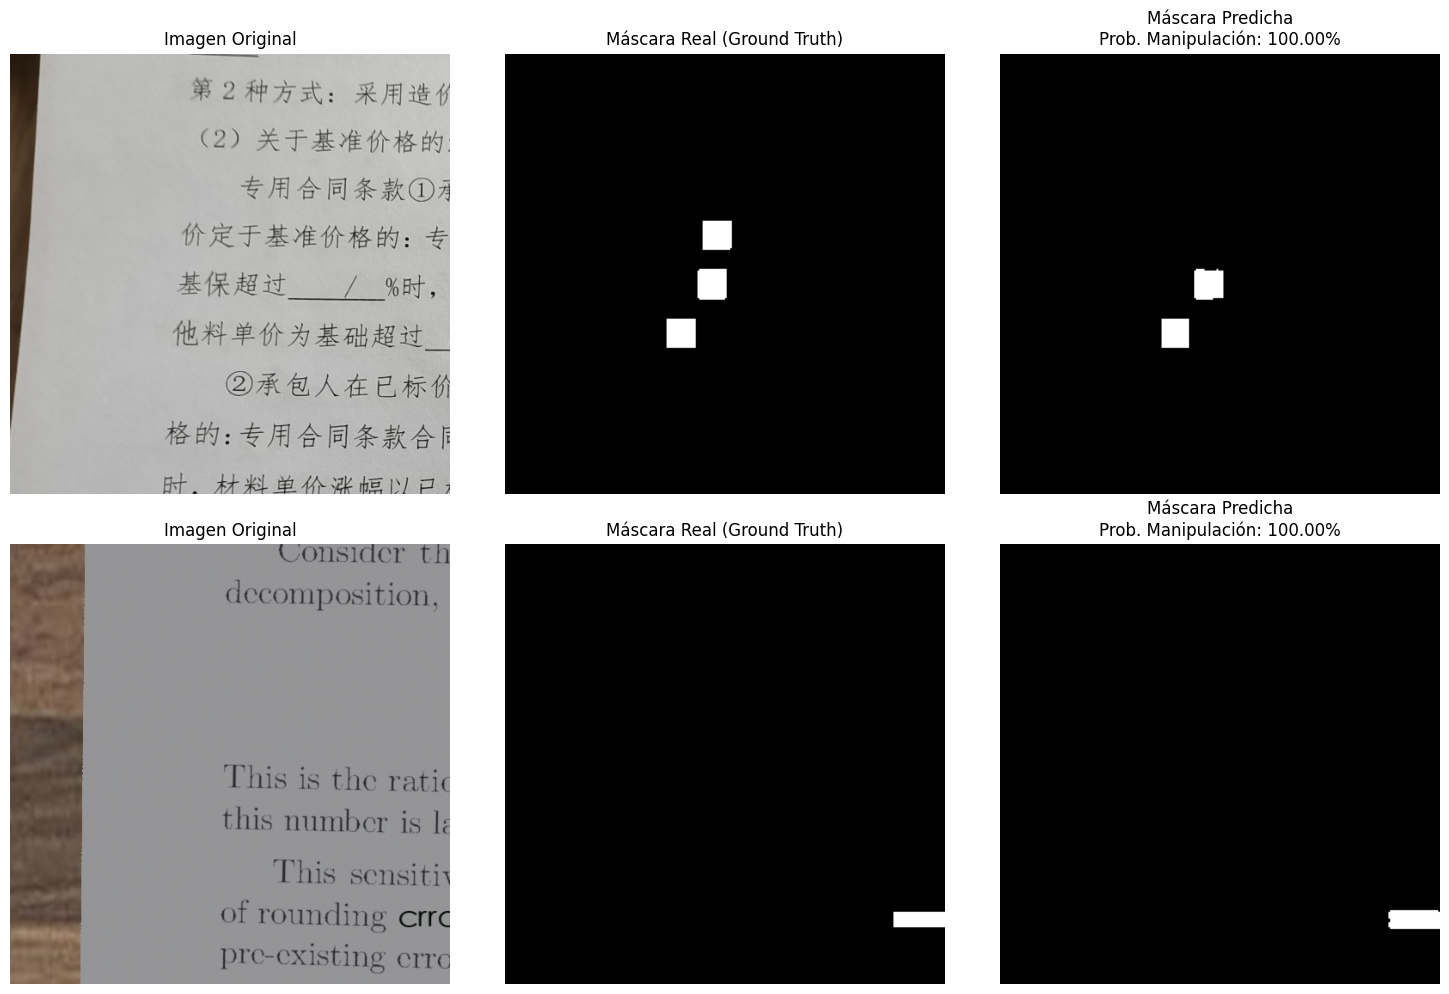

In [68]:
# --- 3. Función para Desnormalizar Imágenes ---
# (Necesaria para visualizar correctamente las imágenes)
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

def unnormalize(tensor, mean, std):
    """Deshace la normalización de un tensor de imagen para visualizarlo."""
    tensor = tensor.clone().cpu() # Mueve a CPU
    tensor = tensor.permute(1, 2, 0)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.numpy()

# --- 4. Realizar y Visualizar Predicciones ---
# Tomamos un lote del val_loader para hacer las pruebas
try:
    images, targets = next(iter(val_loader))
except StopIteration:
    print("Error: El val_loader está vacío.")
    exit()

# Definimos cuántas imágenes del lote queremos visualizar
num_to_show = min(2, len(images))

# Desactivamos el cálculo de gradientes para la inferencia
with torch.no_grad():
    # Movemos el lote de imágenes al dispositivo
    images_device = images.to(DEVICE)
    
    # Hacemos la predicción
    mask_logs, edge_logs, clf_logits = model(images_device)

fig, axs = plt.subplots(num_to_show, 3, figsize=(15, 5 * num_to_show))
if num_to_show == 1:
    axs = [axs]

for i in range(num_to_show):
    # Extraer datos para la i-ésima imagen
    original_img_np = unnormalize(images[i], MEAN, STD)
    
    # --- CAMBIO: Obtenemos también la máscara real ---
    real_mask = targets['mask'][i]
    real_mask_np = real_mask.squeeze().cpu().numpy()
    
    # Procesar la predicción del modelo
    proba_manipulacion = torch.sigmoid(clf_logits[i]).item()
    pred_mask = (torch.sigmoid(mask_logs[i]) > 0.95).float()
    pred_mask_np = pred_mask.squeeze().cpu().numpy()
    
    # --- Gráfica de la Imagen Original ---
    axs[i][0].imshow(original_img_np)
    axs[i][0].set_title("Imagen Original")
    axs[i][0].axis('off')

    # --- Gráfica de la Máscara Real (Ground Truth) ---
    axs[i][1].imshow(real_mask_np, cmap='gray')
    axs[i][1].set_title("Máscara Real (Ground Truth)")
    axs[i][1].axis('off')

    # --- Gráfica de la Máscara Predicha ---
    axs[i][2].imshow(pred_mask_np, cmap='gray')
    axs[i][2].set_title(f"Máscara Predicha\nProb. Manipulación: {proba_manipulacion:.2%}")
    axs[i][2].axis('off')

plt.tight_layout()
plt.show()
plt.show()

In [122]:
def sliding_window_inference(model, full_image, patch_size, stride, device):
    """
    Realiza inferencia en una imagen grande usando una ventana deslizante.
    """
    H, W, C = full_image.shape
    
    prediction_canvas = np.zeros((H, W), dtype=np.float32)
    counts_canvas = np.zeros((H, W), dtype=np.float32)

    preprocess = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    for y in tqdm(range(0, H, stride), desc="Procesando filas"):
        for x in range(0, W, stride):
            if y + patch_size > H: y = H - patch_size
            if x + patch_size > W: x = W - patch_size
            
            patch = full_image[y:y+patch_size, x:x+patch_size]
            processed_patch = preprocess(image=patch)['image']
            
            with torch.no_grad():
                input_tensor = processed_patch.unsqueeze(0).to(device)
                mask_logits, _, _ = model(input_tensor)
                pred_prob = torch.sigmoid(mask_logits).squeeze() # Salida es [256, 256]

                # --- INICIO DE LA CORRECCIÓN ---
                # Redimensionamos la predicción de [256, 256] a [512, 512]
                # para que coincida con el tamaño del parche.
                pred_prob_resized = F.interpolate(
                    pred_prob.unsqueeze(0).unsqueeze(0),
                    size=(patch_size, patch_size),
                    mode='bilinear',
                    align_corners=False
                ).squeeze()
                # --- FIN DE LA CORRECCIÓN ---

                # Convertimos a NumPy para añadirlo al lienzo
                pred_prob_np = pred_prob_resized.cpu().numpy()

            prediction_canvas[y:y+patch_size, x:x+patch_size] += pred_prob_np
            counts_canvas[y:y+patch_size, x:x+patch_size] += 1

    final_probabilities = prediction_canvas / (counts_canvas + 1e-6)
    final_mask = (final_probabilities > 0.95).astype(np.uint8)
    
    return final_mask

Procesando filas: 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]


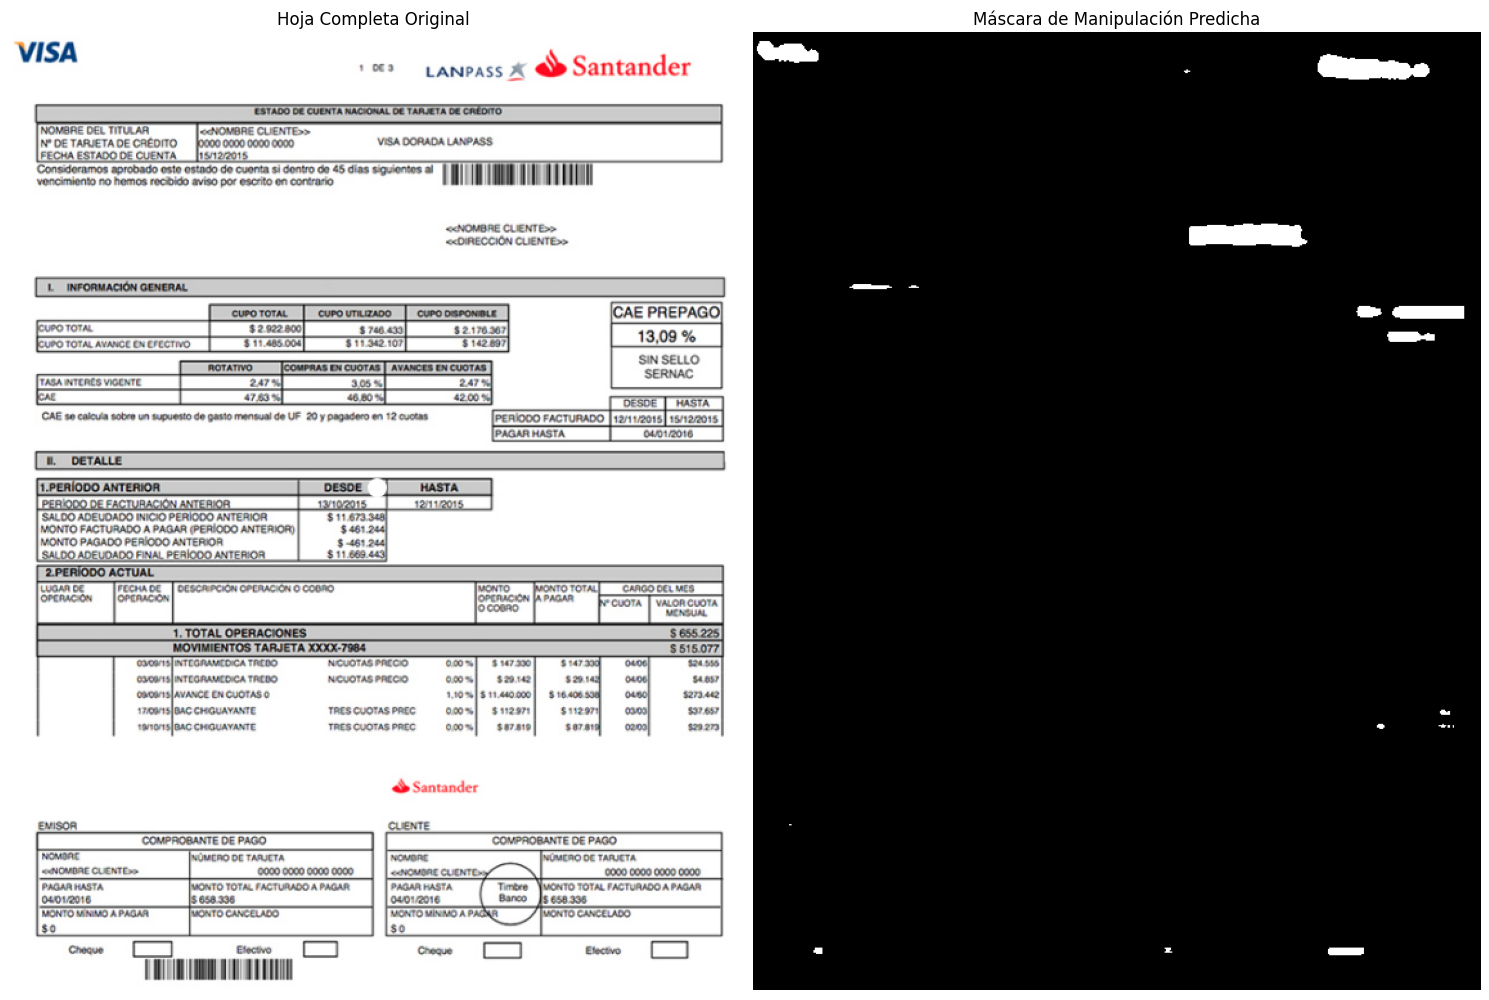

In [123]:

# 1. Configuración (¡ajusta estos valores!)
PATCH_SIZE = 512  # DEBE ser el mismo tamaño que usaste para entrenar
STRIDE = 256      # Distancia de desplazamiento (menor que PATCH_SIZE para solapamiento)

# 2. Carga la imagen de la hoja completa y el modelo
full_page_image = cv2.imread(r"C:\Users\ovill\OneDrive\Escritorio\santander.png")
full_page_image = cv2.cvtColor(full_page_image, cv2.COLOR_BGR2RGB)


# 3. Ejecuta la inferencia con la ventana deslizante
final_prediction_mask = sliding_window_inference(model, full_page_image, PATCH_SIZE, STRIDE, DEVICE)

# 4. Visualiza los resultados
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(full_page_image)
axs[0].set_title("Hoja Completa Original")
axs[0].axis('off')

axs[1].imshow(final_prediction_mask, cmap='gray')
axs[1].set_title("Máscara de Manipulación Predicha")
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [97]:
import fitz  # PyMuPDF
from pathlib import Path

def convertir_pdf_a_imagen(pdf_path: str, output_path: str, dpi: int = 250, page_number: int = 3):
    """
    Convierte una página específica de un archivo PDF a una imagen PNG.

    Args:
        pdf_path (str): Ruta al archivo PDF de entrada.
        output_path (str): Ruta donde se guardará la imagen PNG de salida.
        dpi (int): Puntos por pulgada. Un valor más alto significa mayor resolución. 300 es bueno para calidad.
        page_number (int): El número de la página a convertir (0 es la primera página).
    """
    # Crear la carpeta de salida si no existe
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)
    
    # Abrir el documento PDF
    doc = fitz.open(pdf_path)
    
    # Seleccionar la página (asegurarse de que exista)
    if page_number >= len(doc):
        print(f"Error: El PDF solo tiene {len(doc)} páginas. No se puede acceder a la página {page_number}.")
        doc.close()
        return

    page = doc[page_number]
    
    # Renderizar la página a una imagen (pixmap) con la resolución deseada
    pix = page.get_pixmap(dpi=dpi)
    
    # Guardar la imagen en formato PNG
    pix.save(output_path)
    
    # Cerrar el documento
    doc.close()
    
    print(f"Página {page_number} del PDF guardada como imagen en: {output_path}")



In [ ]:
pdf_de_entrada = r"C:\Users\ovill\OneDrive\Escritorio\1706.03762v7.pdf"
imagen_de_salida = r"C:\Users\ovill\OneDrive\Escritorio\borrar\bbva-estado-cuenta-750.png"

# Llama a la función para convertir la primera página (página 0)
convertir_pdf_a_imagen(pdf_de_entrada, imagen_de_salida)

Página 3 del PDF guardada como imagen en: C:\Users\ovill\OneDrive\Escritorio\borrar\borrar.png
